In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import shap
shap.initjs()

# import custom scripts
from scripts import *

Data utils loaded


In [4]:
# Threshold (%) of data for a feature to be included
THRESHOLD = [0.5, 0.63, 0.75, 0.95, 0.995]
# Depth Threshold (%) of data included from layer data.
# --- picks the maximum depth that includes the threshold % of devices
DEPTH_THRESHOLD = [0.0, 0.25, 0.5, 0.75, 1.0]

EXCLUDED_SECTIONS = [
    "Reference information",
    "Cell definition",
    "Outdoor testing",
    "JV data"
]

EXCLUDED_COLS = [
    "Outdoor_time_start",
    "Outdoor_time_end"
]

TARGET_COL = "JV_default_PCE"

In [5]:
# Process target data
DATABASE.load_data()
mask = DATABASE.data[TARGET_COL].notna()
y = DATABASE.data[mask][TARGET_COL]

Loading Perovskite Data...
Loading Reference Data...
Data Initialized.


In [6]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

numerical_selector = make_column_selector(dtype_include=np.number)
categorical_selector = make_column_selector(dtype_include=[bool, object])

preprocessor = ColumnTransformer([
    ('numerical', 'passthrough', numerical_selector),
    ('categorical', encoder, categorical_selector),
])

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
model = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', xgb_model)
])

clf =  GridSearchCV(
    model,
    {
        "xgb__max_depth": [2, 4, 6],
        "xgb__n_estimators": [50, 100, 200],
    },
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)
clf

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001541B4FF230>),
                                                                        ('categorical',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb__max_depth': [2, 4, 6],
                         'xgb__n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

In [7]:
def _run_gridsearch(model, threshold, depth, xsections, xcols, y, mask):
    data, selector = preprocess_data(
        threshold,
        depth,
        exclude_sections=xsections,
        exclude_cols=xcols,
        verbose=False
    )

    X = data[mask]
    model.fit(X, y)
    df = pd.DataFrame(model.cv_results_)
    df['param_pre__threshold'] = threshold
    df['param_pre__depth'] = depth
    return df

In [8]:
def run_gridsearch(model, target, thresholds, depths, xsections, xcols):
    # Load data, generate mask and target array
    DATABASE.load_data()
    mask = DATABASE.data[target].notna()
    y = DATABASE.data[mask][target]

    # Loop over grid
    n = len(thresholds)
    m = len(depths)
    results = []
    for i in range(n):
        for j in range(m):
            result = _run_gridsearch(model, thresholds[i], depths[j], xsections, xcols, y, mask)
            results.append(result)
    
    return pd.concat(results)

In [9]:
results = run_gridsearch(clf, TARGET_COL, THRESHOLD, DEPTH_THRESHOLD, EXCLUDED_SECTIONS, EXCLUDED_COLS)

Data Initialized.
File already exists: ../../data/preprocessed\expanded_data_d0.0_t0.5_7d6320bdaa910cd5a5ec1d71413a9a1d.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
File already exists: ../../data/preprocessed\expanded_data_d0.25_t0.5_f05af0baf529a3033c3b4f41bb0772c3.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
File already exists: ../../data/preprocessed\expanded_data_d0.5_t0.5_7b3088046d46b1d6413515fd60aef235.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\Violet\Documents\GitHub\PerovskiteML\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


File already exists: ../../data/preprocessed\expanded_data_d0.75_t0.5_df9521a2ce9f055a826b06e12328dffe.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
File already exists: ../../data/preprocessed\expanded_data_d1.0_t0.5_90151cff8700c76e31a3b14ec48edc65.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
File already exists: ../../data/preprocessed\expanded_data_d0.0_t0.63_5786717d2770a2a0f3c57e7dea53c1cf.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
File already exists: ../../data/preprocessed\expanded_data_d0.25_t0.63_78dca2d86697f63d7d8c1a3d25b9e08f.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
File already exists: ../../data/preprocessed\expanded_data_d0.5_t0.63_da19db9350b5d5f39e69cae2e7d7b28e.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\Violet\Documents\GitHub\PerovskiteML\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


File already exists: ../../data/preprocessed\expanded_data_d0.75_t0.63_ba8cc2c0ea04039862baad91822cd338.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
File already exists: ../../data/preprocessed\expanded_data_d1.0_t0.63_67d5cc3dd0c1ee2c9c52856071601ade.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
File already exists: ../../data/preprocessed\expanded_data_d0.0_t0.75_a2ad12c19e1cf604018df7829583b7f1.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
File already exists: ../../data/preprocessed\expanded_data_d0.25_t0.75_b43b04936d7fc37d77871c0df361f791.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
File already exists: ../../data/preprocessed\expanded_data_d0.5_t0.75_be76eba632b91ae515dda53a0890ab03.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
File already exists: ../../data/preprocessed\expanded_data_d0.7

c:\Users\Violet\Documents\GitHub\PerovskiteML\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


File already exists: ../../data/preprocessed\expanded_data_d0.75_t0.995_329349913215658c2b89e5fe44f454b4.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
File already exists: ../../data/preprocessed\expanded_data_d1.0_t0.995_d3e397f19d50e7364a322992ac613982.parquet
Loading Data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\Violet\Documents\GitHub\PerovskiteML\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [10]:
test_pivot = results.pivot_table(values='mean_test_score', index=['param_pre__threshold', 'param_pre__depth'], columns=['param_xgb__max_depth', 'param_xgb__n_estimators'])
test_pivot

param_xgb__max_depth                          2                             4  \
param_xgb__n_estimators                     50        100       200       50    
param_pre__threshold param_pre__depth                                           
0.500                0.00             -4.069738 -4.033780 -4.036780 -4.027153   
                     0.25             -4.084765 -4.038320 -4.013457 -3.983088   
                     0.50             -4.065269 -4.024091 -4.001142 -3.979658   
                     0.75             -4.061991 -4.021709 -3.996470 -3.994100   
                     1.00             -4.032473 -3.994103 -3.968619 -3.962811   
0.630                0.00             -4.070630 -4.030428 -4.035448 -4.056273   
                     0.25             -4.089986 -4.033482 -4.018140 -4.008647   
                     0.50             -4.077138 -4.034698 -4.003071 -3.986634   
                     0.75             -4.063919 -4.024270 -4.010145 -3.989320   
                     1.00             -4.052478 -4.006457 -3.991490 -3.982021   
0.750                0.00             -4.072753 -4.027846 -4.021493 -4.046705   
                     0.25             -4.087246 -4.033670 -4.012086 -4.007479   
                     0.50             -4.073754 -4.031370 -4.009588 -3.980521   
                     0.75             -4.063090 -4.019091 -4.002347 -3.995665   
                     1.00             -4.050404 -4.000283 -3.982441 -3.964994   
0.950                0.00             -4.163829 -4.135587 -4.143161 -4.130047   
                     0.25             -4.235253 -4.190243 -4.188138 -4.151527   
                     0.50             -4.213881 -4.169356 -4.160030 -4.139969   
                     0.75             -4.173723 -4.132295 -4.115759 -4.090419   
                     1.00             -4.179250 -4.147459 -4.134421 -4.113730   
0.995                0.00             -4.329627 -4.318904 -4.356636 -4.290179   
                     0.25             -4.339175 -4.317209 -4.321244 -4.293655   
                     0.50             -4.339175 -4.317209 -4.321244 -4.293655   
                     0.75             -4.321344 -4.309164 -4.319971 -4.292983   
                     1.00             -4.336088 -4.317448 -4.327369 -4.284275   

param_xgb__max_depth                                              6            \
param_xgb__n_estimators                     100       200       50        100   
param_pre__threshold param_pre__depth                                           
0.500                0.00             -4.054264 -4.132759 -4.061729 -4.118651   
                     0.25             -3.988679 -4.018781 -4.000627 -4.035567   
                     0.50             -3.985946 -4.007331 -4.008565 -4.052370   
                     0.75             -3.983693 -4.014131 -3.982124 -3.998359   
                     1.00             -3.950804 -3.979670 -3.949678 -3.957621   
0.630                0.00             -4.079502 -4.157294 -4.088891 -4.154381   
                     0.25             -4.017128 -4.060776 -3.997585 -4.042708   
                     0.50             -3.997941 -4.049052 -3.991492 -4.039200   
                     0.75             -3.981382 -4.016070 -3.990193 -4.016729   
                     1.00             -3.969751 -3.990004 -3.954033 -3.976247   
0.750                0.00             -4.075152 -4.164901 -4.082110 -4.146618   
                     0.25             -4.003607 -4.042549 -4.015775 -4.053349   
                     0.50             -3.983222 -4.012782 -4.009707 -4.043689   
                     0.75             -4.002693 -4.023850 -3.967055 -4.016826   
                     1.00             -3.958561 -3.978190 -3.957628 -3.977010   
0.950                0.00             -4.160138 -4.222312 -4.156641 -4.222912   
                     0.25             -4.168315 -4.200204 -4.161095 -4.203483   
                     0.50             -4.134652 -4.157378 -4.148216 -4.175355   
                     0.75     

In [11]:
train_pivot = results.pivot_table(values='mean_train_score', index=['param_pre__threshold', 'param_pre__depth'], columns=['param_xgb__max_depth', 'param_xgb__n_estimators'])
train_pivot

param_xgb__max_depth                          2                             4  \
param_xgb__n_estimators                     50        100       200       50    
param_pre__threshold param_pre__depth                                           
0.500                0.00             -3.925799 -3.800781 -3.670962 -3.567382   
                     0.25             -3.939877 -3.824635 -3.703572 -3.606613   
                     0.50             -3.940593 -3.819576 -3.692768 -3.594882   
                     0.75             -3.934894 -3.810317 -3.681349 -3.585158   
                     1.00             -3.911985 -3.786267 -3.643173 -3.571409   
0.630                0.00             -3.940927 -3.821396 -3.694522 -3.587296   
                     0.25             -3.959603 -3.842141 -3.722818 -3.624638   
                     0.50             -3.953873 -3.835376 -3.710141 -3.602332   
                     0.75             -3.944026 -3.822032 -3.697707 -3.605553   
                     1.00             -3.922391 -3.801312 -3.662747 -3.592015   
0.750                0.00             -3.941884 -3.821370 -3.691325 -3.597048   
                     0.25             -3.962026 -3.845667 -3.726414 -3.624830   
                     0.50             -3.952806 -3.835676 -3.712321 -3.603216   
                     0.75             -3.944665 -3.823020 -3.697991 -3.596582   
                     1.00             -3.922739 -3.802357 -3.663047 -3.590591   
0.950                0.00             -4.047246 -3.948557 -3.856676 -3.772472   
                     0.25             -4.132855 -4.033788 -3.951756 -3.874864   
                     0.50             -4.107547 -4.008757 -3.922131 -3.833564   
                     0.75             -4.059330 -3.960232 -3.864765 -3.779278   
                     1.00             -4.061720 -3.957595 -3.853725 -3.783037   
0.995                0.00             -4.219473 -4.172217 -4.130293 -4.088475   
                     0.25             -4.222397 -4.172989 -4.130136 -4.094516   
                     0.50             -4.222397 -4.172989 -4.130136 -4.094516   
                     0.75             -4.220792 -4.169213 -4.124373 -4.087252   
                     1.00             -4.218794 -4.166306 -4.121396 -4.084958   

param_xgb__max_depth                                              6            \
param_xgb__n_estimators                     100       200       50        100   
param_pre__threshold param_pre__depth                                           
0.500                0.00             -3.355415 -3.099153 -3.160016 -2.855777   
                     0.25             -3.418558 -3.196799 -3.263096 -2.991426   
                     0.50             -3.403111 -3.177284 -3.234360 -2.964639   
                     0.75             -3.387523 -3.152195 -3.226020 -2.942452   
                     1.00             -3.375045 -3.166198 -3.219731 -2.969658   
0.630                0.00             -3.363360 -3.124027 -3.184138 -2.888501   
                     0.25             -3.440056 -3.236990 -3.297376 -3.027213   
                     0.50             -3.411620 -3.195097 -3.254822 -2.984219   
                     0.75             -3.405862 -3.183589 -3.231225 -2.973978   
                     1.00             -3.397086 -3.179012 -3.258221 -3.001655   
0.750                0.00             -3.379883 -3.148748 -3.203069 -2.908228   
                     0.25             -3.448350 -3.249862 -3.303788 -3.063602   
                     0.50             -3.419330 -3.211425 -3.250093 -3.006644   
                     0.75             -3.402615 -3.190327 -3.249017 -2.989614   
                     1.00             -3.397986 -3.183725 -3.267331 -3.015696   
0.950                0.00             -3.635592 -3.478233 -3.511311 -3.312662   
                     0.25             -3.759383 -3.637596 -3.669401 -3.522402   
                     0.50             -3.701083 -3.559345 -3.598950 -3.435261   
                     0.75     

In [12]:
test_pivot.loc[pd.IndexSlice[:, 1.0], pd.IndexSlice[4, :]]

param_xgb__max_depth                          4                    
param_xgb__n_estimators                     50        100       200
param_pre__threshold param_pre__depth                              
0.500                1.0              -3.962811 -3.950804 -3.979670
0.630                1.0              -3.982021 -3.969751 -3.990004
0.750                1.0              -3.964994 -3.958561 -3.978190
0.950                1.0              -4.113730 -4.106697 -4.124625
0.995                1.0              -4.284275 -4.299097 -4.349540

<Axes: xlabel='param_xgb__max_depth-param_xgb__n_estimators', ylabel='param_pre__threshold-param_pre__depth'>

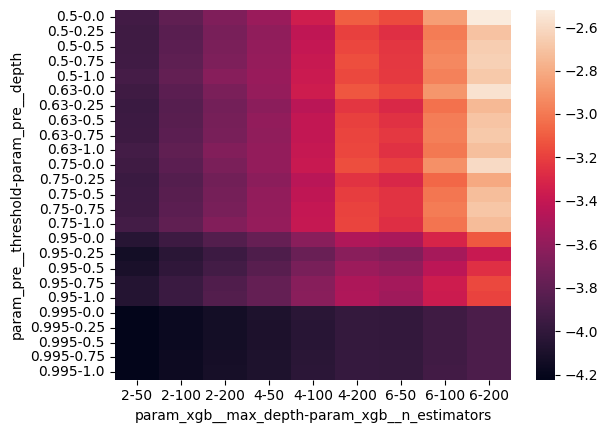

In [13]:
sns.heatmap(train_pivot)

<Axes: xlabel='param_xgb__max_depth-param_xgb__n_estimators', ylabel='param_pre__threshold-param_pre__depth'>

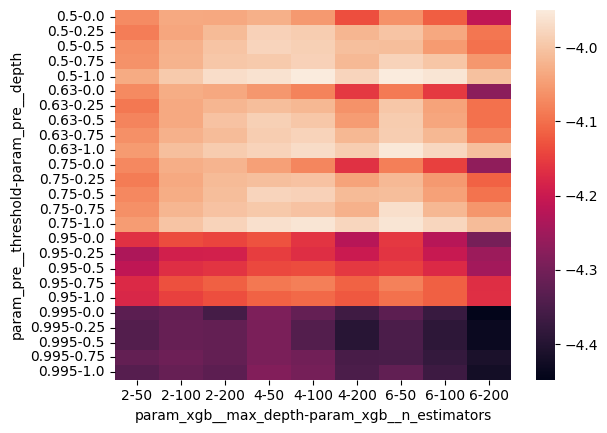

In [14]:
sns.heatmap(test_pivot)

<Axes: xlabel='param_xgb__max_depth-param_xgb__n_estimators', ylabel='param_pre__threshold-param_pre__depth'>

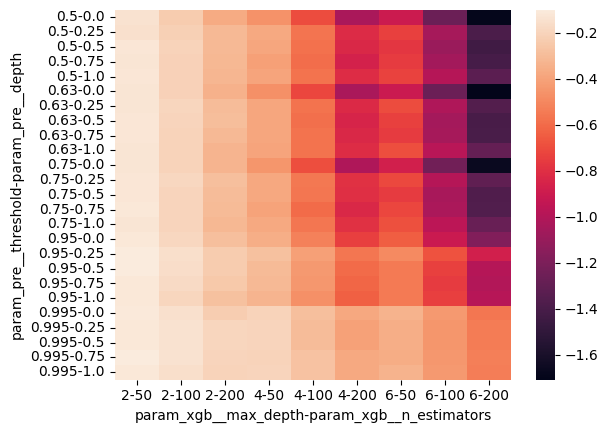

In [15]:
sns.heatmap(test_pivot - train_pivot)

In [16]:
import plotly.express as px

In [17]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__max_depth,param_xgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,param_pre__threshold,param_pre__depth
0,0.678456,0.015016,0.122001,0.004834,2,50,"{'xgb__max_depth': 2, 'xgb__n_estimators': 50}",-4.005620,-4.058248,-3.899734,...,6,-3.937978,-3.944498,-3.959459,-3.903299,-3.883762,-3.925799,0.027944,0.500,0.0
1,0.790377,0.026958,0.124843,0.006728,2,100,"{'xgb__max_depth': 2, 'xgb__n_estimators': 100}",-3.954212,-4.014914,-3.832723,...,2,-3.812061,-3.814026,-3.836560,-3.776251,-3.765006,-3.800781,0.026323,0.500,0.0
2,1.009062,0.044985,0.130238,0.003275,2,200,"{'xgb__max_depth': 2, 'xgb__n_estimators': 200}",-3.916272,-4.024546,-3.830220,...,3,-3.680276,-3.682773,-3.707381,-3.645887,-3.638493,-3.670962,0.025438,0.500,0.0
3,0.836860,0.068563,0.126857,0.016743,4,50,"{'xgb__max_depth': 4, 'xgb__n_estimators': 50}",-3.971325,-3.957341,-3.834008,...,1,-3.568582,-3.577384,-3.595353,-3.554017,-3.541575,-3.567382,0.018593,0.500,0.0
4,0.965913,0.119801,0.134293,0.005616,4,100,"{'xgb__max_depth': 4, 'xgb__n_estimators': 100}",-3.968928,-3.976508,-3.859108,...,4,-3.355680,-3.337843,-3.383879,-3.351183,-3.348490,-3.355415,0.015394,0.500,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.949067,0.034179,0.145316,0.011312,4,100,"{'xgb__max_depth': 4, 'xgb__n_estimators': 100}",-4.279192,-4.249749,-4.058420,...,2,-4.027129,-4.024156,-4.071656,-3.991989,-4.029654,-4.028917,0.025364,0.995,1.0
5,1.224986,0.060417,0.156594,0.014994,4,200,"{'xgb__max_depth': 4, 'xgb__n_estimators': 200}",-4.334625,-4.277486,-4.090032,...,7,-3.971205,-3.974856,-4.018068,-3.939016,-3.983524,-3.977334,0.025336,0.995,1.0
6,0.881866,0.061942,0.146747,0.014658,6,50,"{'xgb__max_depth': 6, 'xgb__n_estimators': 50}",-4.309847,-4.305985,-4.071235,...,4,-3.988775,-3.978387,-4.028037,-3.952106,-3.995465,-3.988554,0.024652,0.995,1.0
7,1.000640,0.026650,0.124786,0.022692,6,100,"{'xgb__max_depth': 6, 'xgb__n_estimators': 100}",-4.350681,-4.311388,-4.087400,...,8,-3.924277,-3.921655,-3.970496,-3.890090,-3.943625,-3.930029,0.026536,0.995,1.0


In [26]:
fig = px.parallel_coordinates(results, color='mean_test_score',
    dimensions=[
        'mean_test_score',
        'param_pre__threshold',
        'param_pre__depth',
        'param_xgb__n_estimators',
        'param_xgb__max_depth',
    ]    
)

In [27]:
fig.show()